In [1]:
# Mall Dataset 기반 사람 수 추정 모델 (Google Colab용)
# (1) 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Analysis Goal
This dataset contains 2000 frames of images from publicly available webcam with detailed head location annotation and total head count. A separate analysis focusing on the stochastic nature of this problem is presented here: [Stochastic Analysis on Pedestrian Flow](https://www.kaggle.com/chaozhuang/stochastic-analysis-on-pedestrian-flow).

Crowd counting can be done in several different forms: region of interest (ROI), line of interest (LOI), and multiple object tracking. ROI methods utilize the density map to generate a count estimate. This method defines the state-of-the-art performance by optimizing for explicit object counting instead of object detection where the detection of size and shape are not required.

ROI method transforms the point annotation into a density map using a Gaussian kernel and then trains a model to predict the density map. The main issue with the method is that it needs an object-specific Gaussian kernel size, which can be compensated by perspective maps or multi-scale deep learning.

Here, we will train and tune a simple CNN model for the counting problem.

In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from tensorflow.keras import  layers , models ,optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
import cv2

# Local
# root = ''

# Kaggle
root = '/content/drive/MyDrive/mall_dataset/mall_dataset/'

# Load annotations and create DataFrame
gt = loadmat(root + 'mall_gt.mat')
df = pd.DataFrame({
    'count': gt['count'].flatten(),
    'annotations': [frame_data[0][0][0] for frame_data in gt['frame'][0]]})
df = df.reset_index()
df = df.rename({'index': 'frame_id'}, axis=1)
df.frame_id = df.index + 1
df['image_name'] = df['frame_id'].apply(lambda x: f'seq_{x:06d}.jpg')

df

,frame_id,count,annotations,image_name
0,1,29,"[[126.77986348122866, 60.70477815699661], [116...",seq_000001.jpg
1,2,30,"[[57.155290102389046, 199.13481228668945], [87...",seq_000002.jpg
2,3,35,"[[118.73899371069183, 43.77044025157227], [134...",seq_000003.jpg
3,4,31,"[[140.87735849056602, 44.77672955974833], [151...",seq_000004.jpg
4,5,26,"[[123.77044025157232, 51.82075471698107], [145...",seq_000005.jpg
...,...,...,...,...
1995,1996,27,"[[454.8737166324436, 45.34599589322369], [462....",seq_001996.jpg
1996,1997,27,"[[367.48151950718693, 59.14476386036961], [395...",seq_001997.jpg
1997,1998,25,"[[22.512320328542103, 245.09958932238186], [73...",seq_001998.jpg
1998,1999,26,"[[22.512320328542103, 290.43839835728943], [99...",seq_001999.jpg


# Setting Up Data Generator

In [3]:
# Scaling factor for density map
scale = 10000

# Function to create a density map
def create_density_map(image_shape, head_locations, sigma=5, scale=scale):
    density_map = np.zeros(image_shape[:2])
    for x, y in head_locations:
        # Adjust head locations for downscaling
        adjusted_x = int(x * (image_shape[1] / 640))
        adjusted_y = int(y * (image_shape[0] / 480))
        density_map[adjusted_y - 1, adjusted_x - 1] += 1
    return gaussian_filter(density_map, sigma=sigma) * scale

class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True):
        self.df = dataframe.sample(frac=1).reset_index(drop=True) if shuffle else dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_df = self.df[idx * self.batch_size:(idx + 1) * self.batch_size]
        X = []
        y = []
        for _, row in batch_df.iterrows():
            # Read and downscale image to grayscale
            img = cv2.imread(root + f'frames/{row.image_name}')
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (160, 120)) / 255.0
            X.append(np.expand_dims(img_resized, axis=-1)) # Add channel dimension for grayscale

            # Create and downscale density map
            density_map = create_density_map(img.shape, row.annotations)
            density_map_resized = cv2.resize(density_map, (160, 120), interpolation=cv2.INTER_AREA)
            y.append(density_map_resized)

        return np.array(X), np.expand_dims(np.array(y), axis=-1)


    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

## Verifying Data Generator

In [4]:
# Split dataset and initialize generators
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_gen = DataGenerator(train_df, batch_size=32)
valid_gen = DataGenerator(valid_df, batch_size=32, shuffle=False)

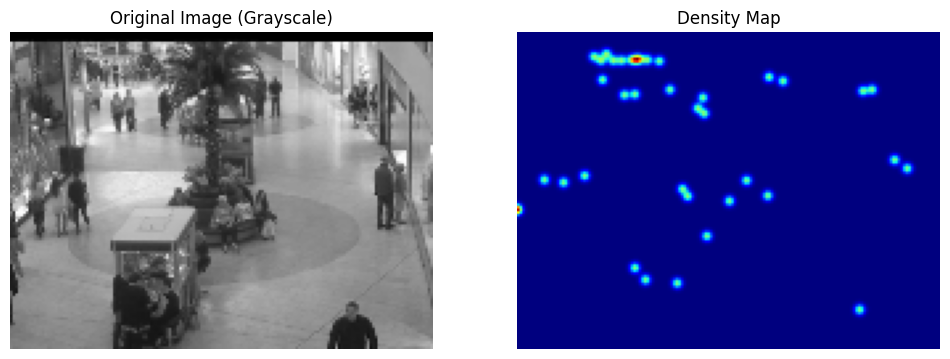

In [5]:
# Fetch the first batch
X_batch, y_batch = train_gen[0]

# Select the first example of the batch
image = X_batch[0]
density_map = y_batch[0].squeeze()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Display grayscale image
axes[0].imshow(image.squeeze(), cmap='gray')
axes[0].set_title('Original Image (Grayscale)')
axes[0].axis('off')

axes[1].imshow(density_map, cmap='jet')
axes[1].set_title('Density Map')
axes[1].axis('off')

plt.show()

# Training a CNN Model

In [ ]:
# Prepare the model
model = Sequential()
# Update input shape to (120, 160, 1) for grayscale images
model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(120, 160, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(4, (9, 9), activation='relu', padding='same'))
model.add(Conv2D(4, (7, 7), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
model.add(Conv2D(8, (5, 5), activation='relu', padding='same'))

# Replace upsampling with deconvolution
model.add(Conv2DTranspose(8, (5, 5), strides=(4, 4), padding='same', activation='relu'))

# Final layer to get the output density map
model.add(Conv2D(1, (1, 1), activation='relu', padding='same'))
model.compile(optimizer=Adam(learning_rate=0.003), loss='mean_squared_error', metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 120, 160, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 60, 80, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 60, 80, 4)      │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 80, 4)      │           788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 40, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 30, 40, 16)     │         3,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 30, 40, 8)      │         3,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 120, 160, 8)    │         1,608 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 120, 160, 1)    │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,105 (39.47 KB)

 Trainable params: 10,105 (39.47 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - loss: 33.8552 - mean_absolute_error: 1.5554

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - loss: 33.8416 - mean_absolute_error: 1.5590 - val_loss: 32.6247 - val_mean_absolute_error: 1.8780
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 984ms/step - loss: 31.5769 - mean_absolute_error: 1.7441 - val_loss: 29.4972 - val_mean_absolute_error: 1.3124
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 981ms/step - loss: 28.3762 - mean_absolute_error: 1.4023 - val_loss: 26.4795 - val_mean_absolute_error: 1.3898
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 989ms/step - loss: 26.0391 - mean_absolute_error: 1.3169 - val_loss: 25.0694 - val_mean_absolute_error: 1.2963
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 981ms/step - loss: 24.4899 - mean_absolute_error: 1.1954 - val_loss: 24.2700 - val_mean_absolute_error: 1.3160
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 983ms/step - loss: 23.5015 - mean_absolute_error: 1.1460 - val_loss: 23.2394 - val_mean_absolute_error: 1.1928
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 973ms/step - loss: 22.7433 - mean_absolute_error

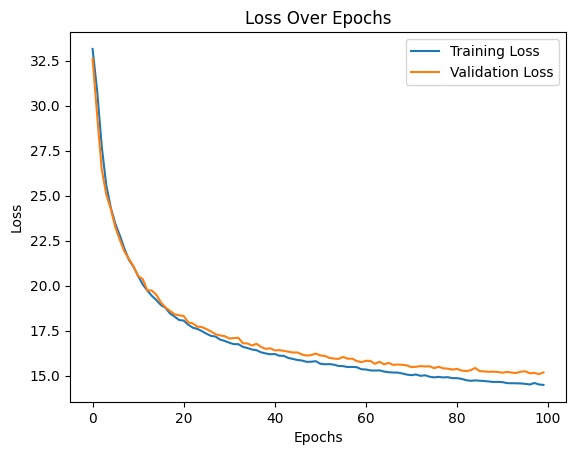

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Integrating Density Map for Head Count Estimation

In [ ]:
all_predictions = []
all_true_counts = []

for i in range(len(valid_gen)):
    batch_x, batch_y = valid_gen[i]
    batch_pred = model.predict(batch_x)
    all_predictions.extend(np.sum(batch_pred, axis=(1, 2, 3)) / scale) # Sum over each predicted density map
    all_true_counts.extend(np.sum(batch_y, axis=(1, 2, 3)) / scale)  # Sum over each true density map

# Compute metrics
mse = mean_squared_error(all_true_counts, all_predictions)
pearson_r, _ = stats.pearsonr(all_true_counts, all_predictions)

print(f'MSE: {mse:.1f}\nPearson r: {pearson_r:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MSE: 0.1
Pearson r: 0.90


## Checking Predicted Map Accuracy

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-20-1575668990.py", line 16, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 213, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 1305, in conv

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 329, in conv

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 317, in _conv_xla

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 304, in _conv

Depth of output must be a multiple of the number of groups: 4 vs 3

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "/tmp/ipython-input-20-1575668990.py", line 16, in <cell line: 0>
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 213, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 1305, in conv
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 329, in conv
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 317, in _conv_xla
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 304, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_105327[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_105358]

In [ ]:
# (1) HDF5 포맷으로 저장 (선택사항)
model.save("/content/drive/MyDrive/people_counter_model.h5")


In [ ]:
import keras
keras.saving.save_model(model, "/content/drive/MyDrive/people_counter_model2.h5")

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 840ms/step


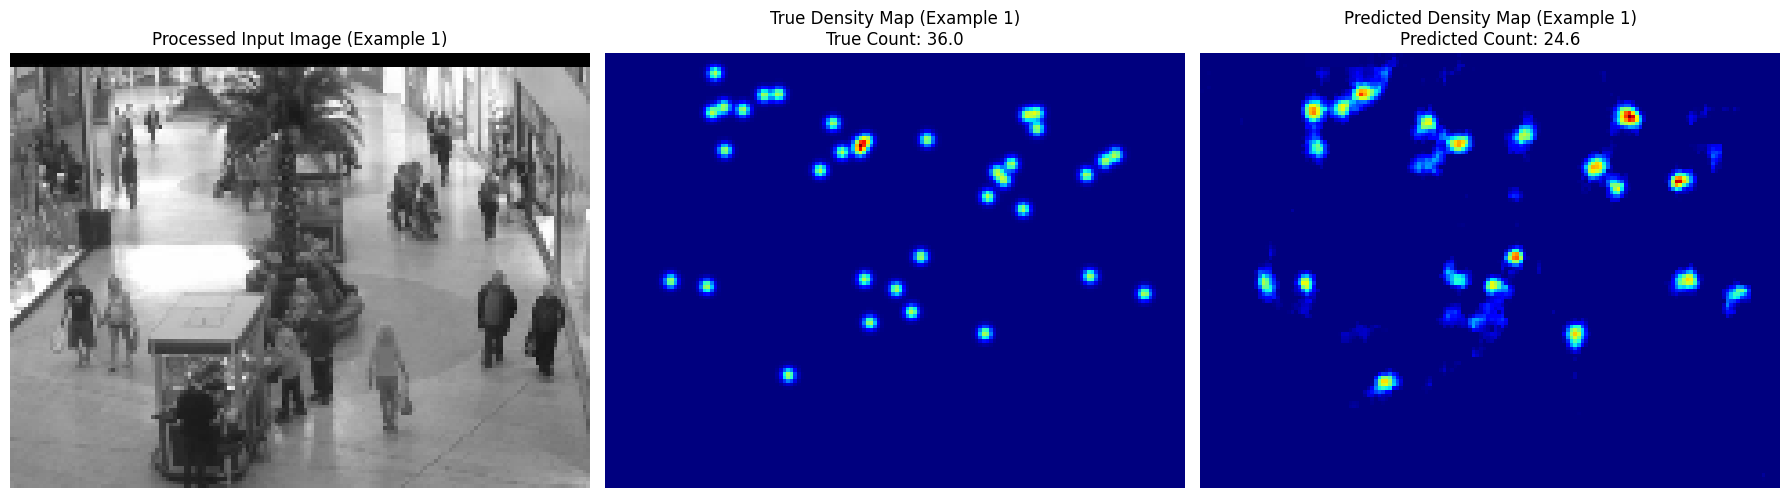

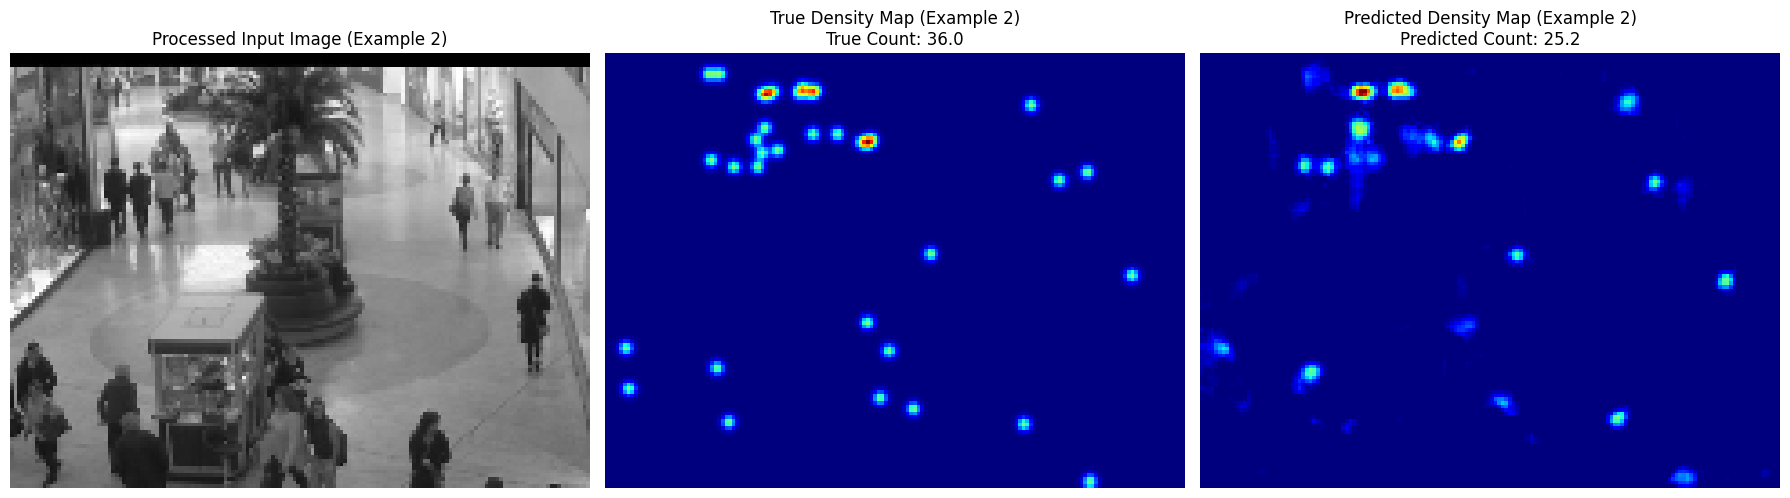

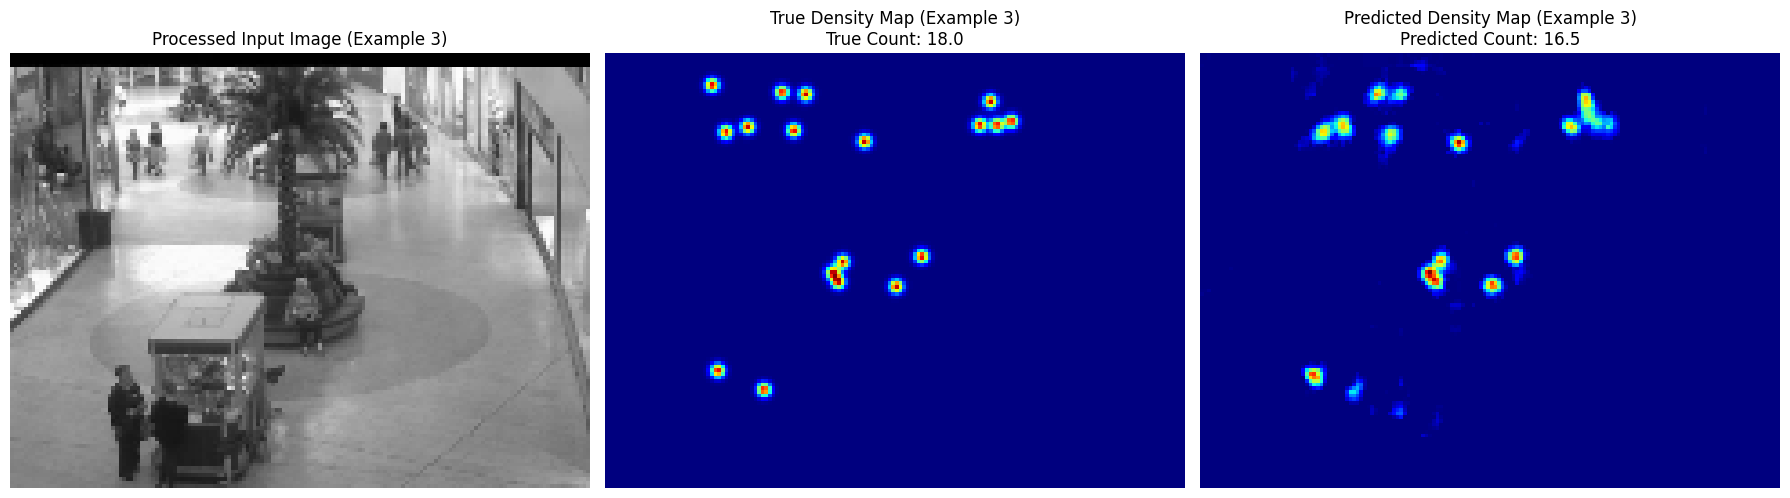

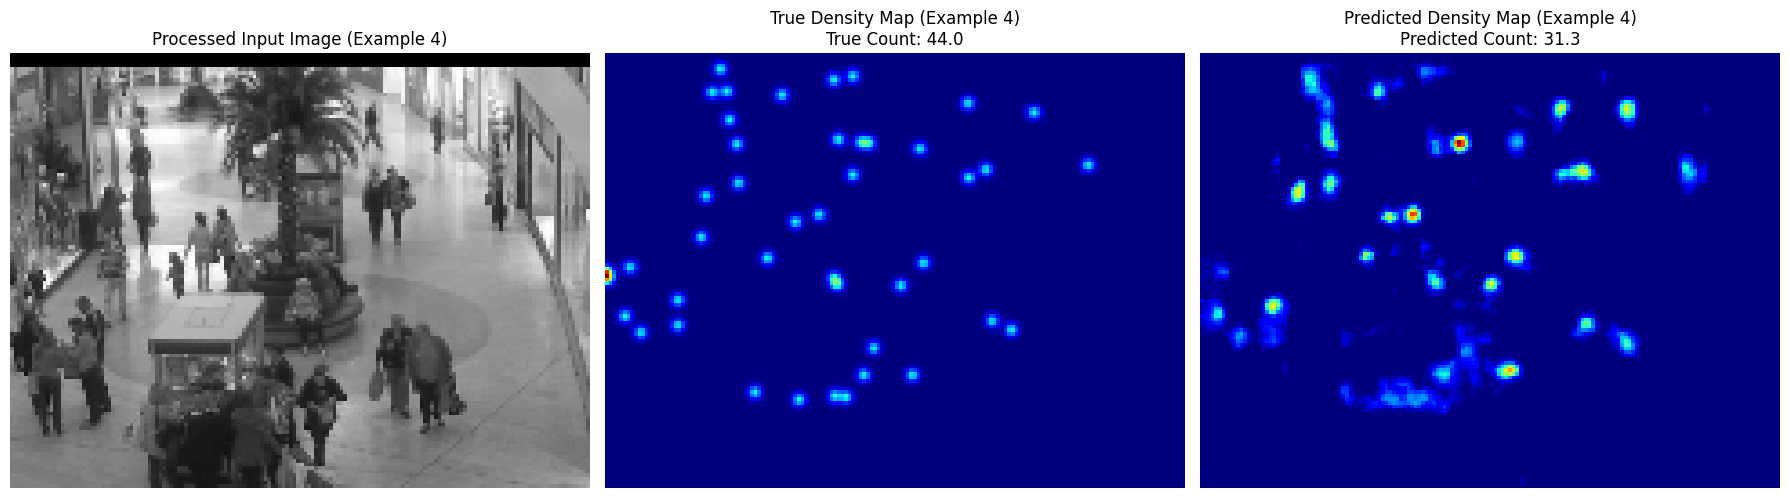

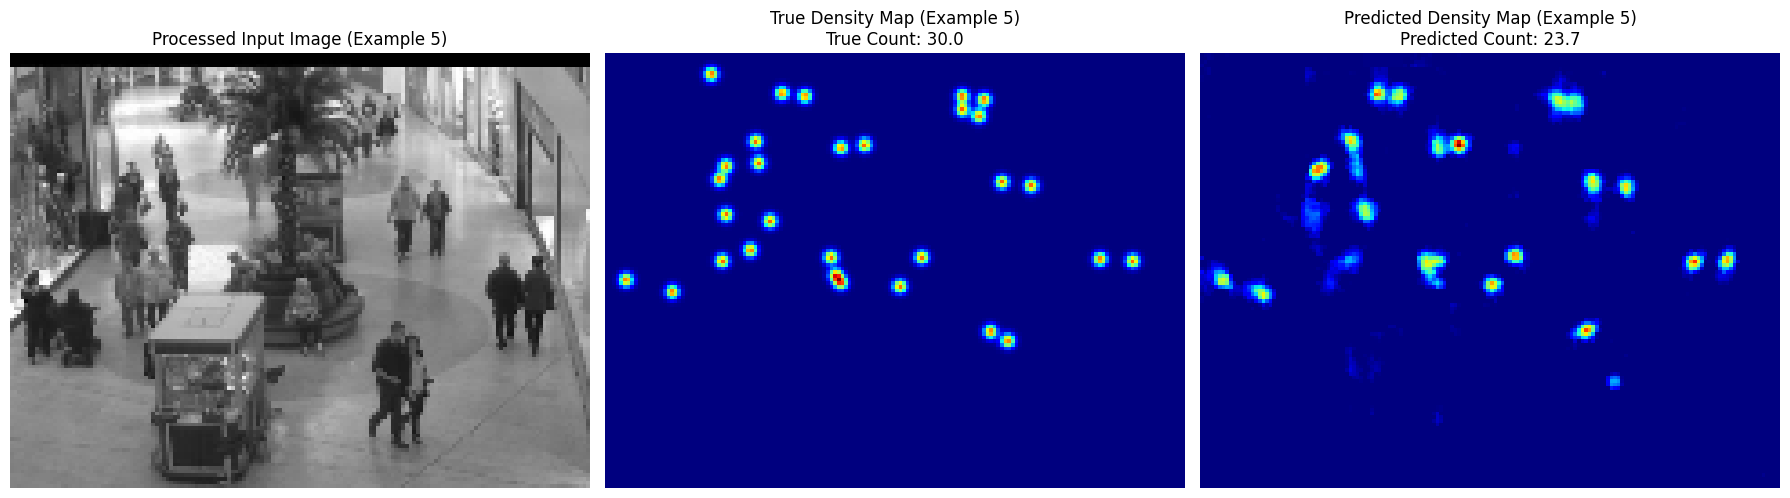

In [ ]:
# prompt: 위의 코드 test 해서 graph 표시하는 코드 작성

import matplotlib.pyplot as plt
import numpy as np
# Get predictions for the validation set
predicted_maps = model.predict(valid_gen)

# Visualize some examples
num_examples_to_show = 5

for i in range(num_examples_to_show):
    # Get the original image, true density map, and predicted density map
    # We need to get the original image from the valid_gen, but it only yields batches of processed images.
    # To show the original, we'll need to access the original dataframe and load the image.
    # A more robust approach might be to modify the generator to also return the original image paths or indices.
    # For simplicity here, we'll assume we can map back to the original dataframe.
    # Note: This mapping can be complex if the validation set was heavily shuffled.
    # A better approach would be to create a separate generator for visualization without shuffling.

    # For this example, we'll just show the processed input image.
    input_image = valid_gen[i // valid_gen.batch_size][0][i % valid_gen.batch_size].squeeze()
    true_density_map = valid_gen[i // valid_gen.batch_size][1][i % valid_gen.batch_size].squeeze()
    predicted_density_map = predicted_maps[i].squeeze()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Display the processed input image
    axes[0].imshow(input_image, cmap='gray')
    axes[0].set_title(f'Processed Input Image (Example {i+1})')
    axes[0].axis('off')

    # Display the true density map
    axes[1].imshow(true_density_map, cmap='jet')
    axes[1].set_title(f'True Density Map (Example {i+1})\nTrue Count: {np.sum(true_density_map)/scale * 16:.1f}')
    axes[1].axis('off')

    # Display the predicted density map
    axes[2].imshow(predicted_density_map, cmap='jet')
    axes[2].set_title(f'Predicted Density Map (Example {i+1})\nPredicted Count: {np.sum(predicted_density_map)/scale * 16:.1f}')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
import tensorflow as tf
smodel = tf.keras.models.load_model('/content/drive/MyDrive/people_counter_model.h5')
smodel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 120, 160, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 60, 80, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 60, 80, 4)      │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 80, 4)      │           788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 40, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 30, 40, 16)     │         3,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 30, 40, 8)      │         3,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 120, 160, 8)    │         1,608 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 120, 160, 1)    │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,107 (39.48 KB)

 Trainable params: 10,105 (39.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(smodel)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

pcqat_tflite_model = converter.convert()
pcqat_model_file = '/content/drive/MyDrive/' + 'tflite_model.tflite'

with open(pcqat_model_file, 'wb') as f:
    f.write(pcqat_tflite_model)

Saved artifact at '/tmp/tmp040bgqdr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 160, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 120, 160, 1), dtype=tf.float32, name=None)
Captures:
  137753905776976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905777744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905780624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905777168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905782544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905783312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905782352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905781968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905784464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905785040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137

In [8]:
tf.lite.experimental.Analyzer.analyze(model_path='/content/drive/MyDrive/tflite_model.tflite')

=== /content/drive/MyDrive/tflite_model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #2 and tensor #1 as input and produces tensor #20 as output.

Subgraph#0 main(T#0) -> [T#31]
  Op#0 CONV_2D(T#0, T#2, T#1) -> [T#20]
  Op#1 MAX_POOL_2D(T#20) -> [T#21]
  Op#2 CONV_2D(T#21, T#19, T#15) -> [T#22]
  Op#3 CONV_2D(T#22, T#8, T#14) -> [T#23]
  Op#4 MAX_POOL_2D(T#23) -> [T#24]
  Op#5 CONV_2D(T#24, T#18, T#13) -> [T#25]
  Op#6 CONV_2D(T#25, T#17, T#12) -> [T#26]
  Op#7 SHAPE(T#26) -> [T#27]
  Op#8 STRIDED_SLICE(T#27, T#4[0], T#3[1], T#3[1]) -> [T#28]
  Op#9 PACK(T#28, T#7[120], T#6[160], T#5[8]) -> [T#29]
  Op#10 TRANSPOSE_CONV(T#29, T#16, T#26, T#11) -> [T#30]
  Op#11 CONV_2D(T#30, T#9, T#10) -> [T#31]

Tensors of Subgraph#0
  T#0(serving_default_input_layer_1:0) shape_signature:[-1, 120, 160, 1], type:FLOAT32
  T#1(arith.constant) shape:[4], type:FL

In [17]:

print(density_map)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
# prompt: 위의 코드 int8로 양자화

import numpy as np
converter.target_spec.supported_types = [tf.int8]

def representative_dataset_gen():
    # Iterate over a small subset of your training data
    # This is crucial for integer quantization
    num_calibration_steps = 100 # Or a suitable number based on your dataset size
    for i in range(num_calibration_steps):
        # Get a batch of data from your generator
        x, _ = train_gen[i]
        yield [x.astype(np.float32)] # Ensure data is float32

converter.representative_dataset = representative_dataset_gen
converter.inference_input_type = tf.int8  # Or tf.uint8 depending on your model requirements
converter.inference_output_type = tf.int8 # Or tf.uint8

pcqat_tflite_model_int8 = converter.convert()
pcqat_model_file_int8 = '/content/drive/MyDrive/' + 'tflite_model_int8.tflite'

with open(pcqat_model_file_int8, 'wb') as f:
    f.write(pcqat_tflite_model_int8)

tf.lite.experimental.Analyzer.analyze(model_path='/content/drive/MyDrive/tflite_model_int8.tflite')


Saved artifact at '/tmp/tmpi53qemj1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 160, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 120, 160, 1), dtype=tf.float32, name=None)
Captures:
  137753905776976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905777744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905780624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905777168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905782544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905783312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905782352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905781968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905784464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753905785040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


KeyboardInterrupt: 

In [18]:
# Iterate through the density map and print non-zero values
found_nonzero = False
for row in density_map:
    for value in row:
        if value != 0:
            print(value)
            found_nonzero = True
            # You can adjust the number of non-zero values to print
            # For example, to print only the first non-zero value, uncomment the break statements below:
            # break
    # if found_nonzero:
    #     break

if not found_nonzero:
    print("No non-zero values found in the density map.")

1.4246606049482846e-06
4.811834147604071e-05
0.0005144311588028563
0.002973616605412327
0.009320752010873415
0.015877223434093327
0.014714218538592286
0.007417687154529088
0.0020312290570270513
0.00030141434309398964
2.4163708876208684e-05
2.4163708876208688e-05
0.00030141434309398964
0.0020312290570270513
0.007417687154529088
0.014743195300294392
0.01685592229725342
0.019783980269585846
0.06345523550410422
0.1900930641085921
0.3229815372504206
0.29928000563954227
0.15087140917002723
0.041314008503804595
0.006130591077689531
0.0004914756760403359
0.0004914756760403359
0.006130591077689532
0.041314008503804595
0.15087140917002723
0.29954414669277324
0.33190298096344534
0.28547184248504454
0.614782491505041
1.7479101350223103
2.9605931925626865
2.7428520296116123
1.3827036259458392
0.37863389541347603
0.056185532825238305
0.004507739694126744
5.3414614763711014e-05
0.00042733063084999536
0.0018918427492480687
0.004934565895202385
0.00885089120885543
0.013854414264471551
0.019488206633723